test, komt later

In [24]:
# importeer de benodigde bibliotheken, dan gaat het later sneller 
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from kaggle.api.kaggle_api_extended import KaggleApi
import os
import zipfile
from pathlib import Path

from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV, RandomizedSearchCV
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
from catboost import CatBoostRegressor
from tqdm import tqdm_notebook, tqdm

import random
import warnings


# interactieve modus inschakelen en output verbreden
%matplotlib inline
pd.set_option('display.width', 800)

# remove future warnings
warnings.simplefilter('ignore')
warnings.filterwarnings("ignore")

seed = 42

api = KaggleApi()
api.authenticate()

# path settings
from pathlib import Path
p = Path()
download_path = p / 'data'
output_path = p / 'output'
images_path = p / 'images'

# Create the output directory if it does not exist
if not os.path.exists(output_path):
		os.makedirs(output_path)
# Create the images directory if it does not exist
if not images_path.exists():
	images_path.mkdir(parents=True, exist_ok=True)

# Functie om de output van de gemaakte plots te bewaren
def save_fig(fig_name, tight_layout=True, fig_extension="png", resolution=300):
    path = images_path / f"{fig_name}.{fig_extension}"
    if tight_layout:
        plt.tight_layout()
    plt.savefig(path, format=fig_extension, dpi=resolution)


## Inlezen dataset

In [25]:
train_raw = pd.read_csv('data/train.csv')
test = pd.read_csv('data/test.csv')
sample_submission = pd.read_csv('data/sample_submission.csv')
data = train_raw.copy()

## Bestuderen van de data

In [26]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 266325 entries, 0 to 266324
Data columns (total 17 columns):
 #   Column               Non-Null Count   Dtype  
---  ------               --------------   -----  
 0   ID                   266325 non-null  int64  
 1   fullAddress          266325 non-null  object 
 2   postcode             266325 non-null  object 
 3   country              266325 non-null  object 
 4   outcode              266325 non-null  object 
 5   latitude             266325 non-null  float64
 6   longitude            266325 non-null  float64
 7   bathrooms            217846 non-null  float64
 8   bedrooms             241482 non-null  float64
 9   floorAreaSqM         252519 non-null  float64
 10  livingRooms          229285 non-null  float64
 11  tenure               260604 non-null  object 
 12  propertyType         265817 non-null  object 
 13  currentEnergyRating  209511 non-null  object 
 14  sale_month           266325 non-null  int64  
 15  sale_year        

Functie om NaN-waarden te behandelen     

In [27]:
# Functie om NaN-waarden te behandelen

# Lijst om kolommen met >50% missende waarden op te slaan
cols_to_drop = []

def fill_missing_values(df):
    for col, missing_count in df.isnull().sum().items():
        missing_ratio = missing_count / len(df)
        
        if 0 < missing_ratio <= 0.5:
            if df[col].dtype == object:  # Categorische kolommen
                df[col] = df[col].fillna(df[col].mode()[0])
            else:  # Numerieke kolommen
                df[col] = df[col].fillna(df[col].median())
        
        elif missing_ratio > 0.5: # meer dan de helft van de waarden ontbreken
            cols_to_drop.append(col)

# Kolommen met te veel missende waarden verwijderen
data = data.drop(columns=cols_to_drop)

del cols_to_drop  # Opschoonactie

Functie voor het evalueren van een lijst met modellen op basis van statistieken MAE, MSE, RMSE, R² и MAPE.    

*Kan ook later ingevoegd worden, maar het is hier waar de magic happens*


In [28]:
def evaluate_models(models, model_names, X, y) -> pd.DataFrame:

    """
    Functie voor het evalueren van een lijst met modellen op basis van statistieken MAE, MSE, RMSE, R² и MAPE.

    Opties:
    models (list): Lijst met getrainde modellen
    model_names (list): Lijst met genoemde modellen
    X (numpy.ndarray): trainingsset, shape (n_samples, n_features)
    Y (numpy.ndarray): Target, shape (n_samples,)
    
    Output:
    pandas.DataFrame: Tabel met statistieken voor elk mode
    """

    if len(models) != len(model_names):
        raise ValueError("Lijsten met modellen en modelnamen moeten dezelfde lengte hebben")

    results = []
    for model, name in zip(models, model_names):
        y_pred = model.predict(X)
        
        # Regressiestatistieken berekenen
        mae = mean_absolute_error(y, y_pred)
        mse = mean_squared_error(y, y_pred)
        rmse = np.sqrt(mse)  # root mean squared error
        r2 = r2_score(y, y_pred)
        
        # Gemiddelde absolute procentuele fout (MAPE)
        mape = np.mean(np.abs((y - y_pred) / y)) * 100 if np.all(y != 0) else None

        results.append({
            'Model': name,
            'MAE': round(mae, 4),
            'MSE': round(mse, 4),
            'RMSE': round(rmse, 4),
            'R²': round(r2, 4),
            'MAPE': round(mape, 4)
        }) 

    results_df = pd.DataFrame(results)

    return results_df

Om het geheugengebruik te verminderen alle kolommen van een DataFrame doorlopen en besparen waar het kan door het het gegevenstype te wijzigen
        

In [29]:
def reduce_mem_usage(df: pd.DataFrame) -> pd.DataFrame:
    """ Om het geheugengebruik te verminderen alle kolommen 
        van een DataFrame doorlopen en besparen waar het kan 
        door het het gegevenstype te wijzigen
    """
    start_mem = df.memory_usage().sum() / 1024**2
    print('Memory usage of dataframe is {:.2f} MB'.format(start_mem))

    for col in df.columns:
        col_type = df[col].dtype.name


        if col_type not in ['object', 'category', 'datetime64[ns, UTC]']:
            c_min = df[col].min()
            c_max = df[col].max()
            if str(col_type)[:3] == 'int':
                if c_min > np.iinfo(np.int8).min and c_max < np.iinfo(np.int8).max:
                    df[col] = df[col].astype(np.int8)
                elif c_min > np.iinfo(np.int16).min and c_max < np.iinfo(np.int16).max:
                    df[col] = df[col].astype(np.int16)
                elif c_min > np.iinfo(np.int32).min and c_max < np.iinfo(np.int32).max:
                    df[col] = df[col].astype(np.int32)
                elif c_min > np.iinfo(np.int64).min and c_max < np.iinfo(np.int64).max:
                    df[col] = df[col].astype(np.int64)
            else:
                if c_min > np.finfo(np.float16).min and c_max < np.finfo(np.float16).max:
                    df[col] = df[col].astype(np.float16)
                elif c_min > np.finfo(np.float32).min and c_max < np.finfo(np.float32).max:
                    df[col] = df[col].astype(np.float32)
                else:
                    df[col] = df[col].astype(np.float64)

    end_mem = df.memory_usage().sum() / 1024 ** 2
    print('Memory usage after optimization is: {:.2f} MB'.format(end_mem))
    print('Decreased by {:.1f}%'.format(100 * (start_mem - end_mem) / start_mem))
    return df

# Profiling
Om een eerste indruk te krijgen over de dataset, maken we gebruik van een profiler.   
In het geëxporteerde bestand /output/profiler_1_CBR.html krijg je een mooi overzicht van alle data waaruit deze dataset is opgebouwd.   

Belangrijk: dit moet gebeuren vooraleer we de types wijzigen om geheugen te sparen. 

In [30]:
##########################
# PROFILER HTML DOCUMENT #
##########################

from ydata_profiling import ProfileReport
import os
import webbrowser
# controleer of er al een rapport is
profiler_file = 'output/profiler_1_CBR.html'
if os.path.exists(profiler_file):
	print(f"profiler betsaat al. Openen...")
else:
	# Generate the profiling report, kies een goede titel
	profile = ProfileReport(data, title="Baseline London-house-price Report", explorative=True) # explorative=True om ook de correlaties te zien

	# Create the output directory if it does not exist
	output_dir = "output"
	if not os.path.exists(output_dir):
		os.makedirs(output_dir)

	# Save the report as an HTML file
	profiler_file = "profiler_1_CBR.html"
	profile.to_file(os.path.join(output_dir,profiler_file))

	# Pad naar je bestand
	profiler_path = os.path.abspath(os.path.join(output_dir, profiler_file))
	print(f"profiler gemaakt: {profiler_path}")

# Open het bestand in de standaardbrowser
webbrowser.open(f"file://{profiler_path}")




profiler betsaat al. Openen...


True

## Hier kan je ook nog een goed beeld krijgen van de data

In [31]:
# Uit te voeren als je wat geheugen wilt besparen
data = reduce_mem_usage(data)
test = reduce_mem_usage(test)
data.info() # om te zien wat er gewijzigd werd, let op de int en float types

Memory usage of dataframe is 34.54 MB
Memory usage after optimization is: 20.07 MB
Decreased by 41.9%
Memory usage of dataframe is 2.02 MB
Memory usage after optimization is: 1.18 MB
Decreased by 41.4%
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 266325 entries, 0 to 266324
Data columns (total 17 columns):
 #   Column               Non-Null Count   Dtype  
---  ------               --------------   -----  
 0   ID                   266325 non-null  int32  
 1   fullAddress          266325 non-null  object 
 2   postcode             266325 non-null  object 
 3   country              266325 non-null  object 
 4   outcode              266325 non-null  object 
 5   latitude             266325 non-null  float16
 6   longitude            266325 non-null  float16
 7   bathrooms            217846 non-null  float16
 8   bedrooms             241482 non-null  float16
 9   floorAreaSqM         252519 non-null  float16
 10  livingRooms          229285 non-null  float16
 11  tenure             

In [32]:
# Overzicht numerische waarden
data.describe()

,ID,latitude,longitude,bathrooms,bedrooms,floorAreaSqM,livingRooms,sale_month,sale_year,price
count,266325.000000,266325.00000,266325.000000,217846.0,241482.0,252519.0,229285.0,266325.000000,266325.000000,2.663250e+05
mean,133162.000000,NaN,-0.000000,NaN,NaN,NaN,NaN,6.805670,2012.213855,6.161788e+05
std,76881.549558,0.00000,0.000000,0.0,0.0,NaN,0.0,3.356693,9.143113,1.274105e+06
min,0.000000,51.37500,-0.347168,1.0,1.0,10.0,1.0,1.000000,1995.000000,1.000000e+04
25%,66581.000000,51.46875,-0.159180,1.0,2.0,63.0,1.0,4.000000,2004.000000,2.165000e+05
50%,133162.000000,51.50000,-0.108643,1.0,2.0,85.0,1.0,7.000000,2014.000000,3.850000e+05
75%,199743.000000,51.56250,-0.049194,2.0,3.0,118.0,1.0,10.000000,2021.000000,6.500000e+05
max,266324.000000,51.65625,0.139282,9.0,9.0,500.0,9.0,12.000000,2023.000000,1.000000e+08


In [33]:
# controleren of er nog missende waarden zijn
data.isnull().sum() 

ID                         0
fullAddress                0
postcode                   0
country                    0
outcode                    0
latitude                   0
longitude                  0
bathrooms              48479
bedrooms               24843
floorAreaSqM           13806
livingRooms            37040
tenure                  5721
propertyType             508
currentEnergyRating    56814
sale_month                 0
sale_year                  0
price                      0
dtype: int64

In [34]:
# controleren of er nog missende waarden zijn
test.isnull().sum()


ID                        0
fullAddress               0
postcode                  0
country                   0
outcode                   0
latitude                  0
longitude                 0
bathrooms              2624
bedrooms               1375
floorAreaSqM           2006
livingRooms            2095
tenure                  590
propertyType            167
currentEnergyRating    1497
sale_month                0
sale_year                 0
dtype: int64

In [35]:
list(test.isnull().sum().items())

[('ID', 0),
 ('fullAddress', 0),
 ('postcode', 0),
 ('country', 0),
 ('outcode', 0),
 ('latitude', 0),
 ('longitude', 0),
 ('bathrooms', 2624),
 ('bedrooms', 1375),
 ('floorAreaSqM', 2006),
 ('livingRooms', 2095),
 ('tenure', 590),
 ('propertyType', 167),
 ('currentEnergyRating', 1497),
 ('sale_month', 0),
 ('sale_year', 0)]

## Werk aan de winkel   
Zowel voor de **data** als de **test** gaan we de lege waarden als volgt opvullen:     
- Als de kolom **categorisch** is: vul de NaN’s met de modale waarde (meest voorkomende waarde).   
- Anders (**numeriek**): vul de NaN’s met de mediaan.   

Voor kolommen met meer dan helft lege waarden: droppen die handel 

In [36]:
# Missende waarden invullen in test- en train-data en kilommen met te veel lege waarden droppen
# alleen uitvoeren indien nog lege waarden
if data.isnull().sum().sum() > 0:
    fill_missing_values(test)
    fill_missing_values(data)
    print(f"De lege waarden werdenn opgevuld en de kolommen met te veel missende waarden zijn verwijderd")
else:
    print("Er zijn geen missende waarden")

# Onnodige cols schrappen
# alleen uitvoeren indien de kolommen nog aanwezig zijn
if 'ID' in data.columns:
    data = data.drop(columns=['ID', 'country'])
    print(f"De kolommen 'ID' en 'country' zijn verwijderd")



De lege waarden werdenn opgevuld en de kolommen met te veel missende waarden zijn verwijderd
De kolommen 'ID' en 'country' zijn verwijderd


## Training time    

we kunnen gaan trainen, maar eerst:    
Vermits de prijs een extreme skewness heeft, met extreem hoge waarde, ga ik hierop een log-transformatie toepassen 

<Axes: >

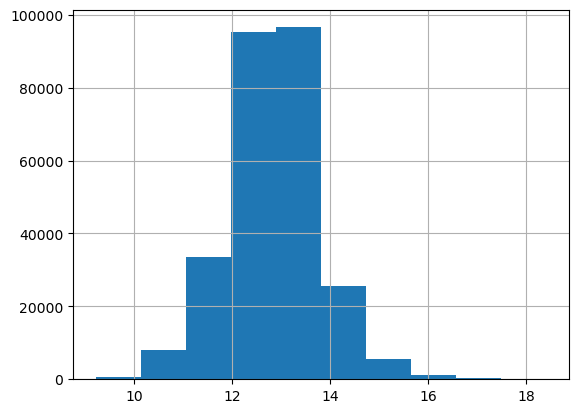

In [37]:
data.price = np.log(data.price)
data.price.hist()

In [38]:
# TRain-Test-Split, let hier op dat we met een validatie set werken (en geen test set)

X =  data.drop(columns=['price'])
y =  data['price']
X_train, X_valid, y_train, y_valid = train_test_split(X, y,
    test_size=0.2,
    shuffle=True,
    random_state=seed
)

## CatBoostRegressor

In [39]:
cbr = CatBoostRegressor(
    use_best_model=True,
    random_state=seed,
    verbose=100 # to see the progress, but not all
)
cbr.fit(
    X_train,
    y_train,
    eval_set=(X_valid, y_valid),
    cat_features=['postcode', 'outcode', 'tenure', 'propertyType', 'currentEnergyRating'],
    text_features=['fullAddress'],
    early_stopping_rounds=128
)

Learning rate set to 0.11816
0:	learn: 0.8549621	test: 0.8510814	best: 0.8510814 (0)	total: 691ms	remaining: 11m 30s
100:	learn: 0.3653982	test: 0.3602122	best: 0.3602122 (100)	total: 33.2s	remaining: 4m 55s
200:	learn: 0.3513743	test: 0.3484890	best: 0.3484890 (200)	total: 1m 1s	remaining: 4m 2s
300:	learn: 0.3443589	test: 0.3437540	best: 0.3437540 (300)	total: 1m 28s	remaining: 3m 24s
400:	learn: 0.3389735	test: 0.3404785	best: 0.3404785 (400)	total: 1m 54s	remaining: 2m 51s
500:	learn: 0.3349800	test: 0.3385307	best: 0.3385307 (500)	total: 2m 20s	remaining: 2m 19s
600:	learn: 0.3313665	test: 0.3367478	best: 0.3367478 (600)	total: 2m 46s	remaining: 1m 50s
700:	learn: 0.3283464	test: 0.3355754	best: 0.3355754 (700)	total: 3m 12s	remaining: 1m 22s
800:	learn: 0.3255823	test: 0.3344802	best: 0.3344798 (797)	total: 3m 38s	remaining: 54.3s
900:	learn: 0.3231823	test: 0.3336236	best: 0.3336135 (898)	total: 4m 3s	remaining: 26.8s
999:	learn: 0.3208530	test: 0.3328406	best: 0.3328406 (999)	t

In [40]:
evaluate_models(
    [cbr],
    ['CatBoostRegressor'],
    X_valid, y_valid
)

,Model,MAE,MSE,RMSE,R²,MAPE
0,CatBoostRegressor,0.1994,0.1108,0.3328,0.8704,1.5739


## Als we klaar zijn, kunnen we het resultaat indienen    

In [41]:
y_pred_log = cbr.predict(test[X_train.columns.tolist()])
y_pred = np.round(np.expm1(y_pred_log),0).astype(int)


In [42]:
# nodig om het resultaat in te dienen
sub = sample_submission.copy()
sub['price'] = y_pred
sub.to_csv('output/submission_cbr_log.csv', index=False)
sub

,ID,price
0,266325,426191
1,266326,364831
2,266327,262899
3,266328,381452
4,266329,448172
...,...,...
16542,282867,302729
16543,282868,302729
16544,282869,385624
16545,282870,875268
